# On-Chain Analysis of Smart Contract Dependency Risks on Ethereum

This notebook provides the visualizations for each RQ.

## RQ1: What is the scale of smart contract dependencies in the field?
Metrics:
- Created contracts (C)
- Destructed contracts (D)
- Alive contracts (A)
- Contracts per tansaction (I_t)
- Types of calls:
    + regular calls P_r
    + delegate calls P_d
    + static calls P_s 

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import networkx as nx
from matplotlib.patches import Patch
import networkx as nx
import nxviz as nv
from nxviz import annotate
import numpy as np

Setting global plot parameters:

In [28]:
plt.rcParams.update({
    'font.size': 16,  
    'axes.labelsize': 18, 
    'axes.labelweight': 'bold',
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

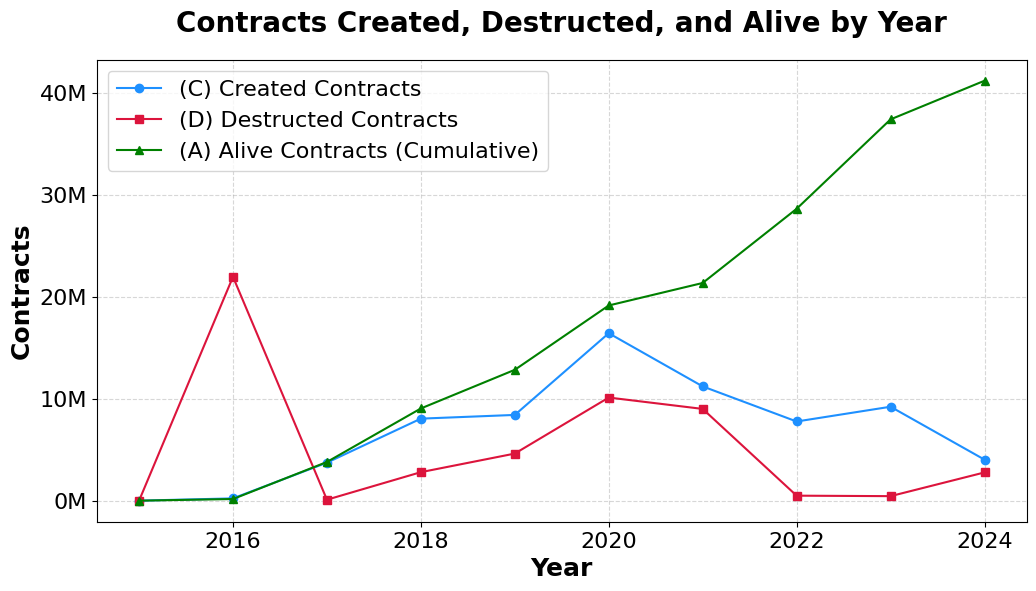

In [29]:
# Load data
create_df = pd.read_csv("../results/rq1/create_by_year.csv")
destruct_df = pd.read_csv("../results/rq1/destruct_by_year.csv")
alive_df = pd.read_csv("../results/rq1/alive_contracts_year.csv")

# Create the plot
plt.figure(figsize=(12, 6))  # Ensure same height


# Plot creation
plt.plot(create_df["year"], create_df["create_trace_count"], marker='o', linestyle='-', color='dodgerblue', label="(C) Created Contracts")

# Plot destruction
plt.plot(destruct_df["year"], destruct_df["destruct_trace_count"], marker='s', linestyle='-', color='crimson', label="(D) Destructed Contracts")

# Plot alive contracts
plt.plot(alive_df["year"], alive_df["n_alive_contracts"], marker='^', linestyle='-', color='green', label="(A) Alive Contracts (Cumulative)")

# Labels and title
plt.xlabel("Year", fontsize=18, fontweight='bold')
plt.ylabel("Contracts", fontsize=18, fontweight='bold')
plt.title("Contracts Created, Destructed, and Alive by Year", fontsize=20, pad=20, fontweight='bold')

# Format y-axis labels as 10M, 20M, etc.
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000_000)}M'))  # Convert to millions
ax.yaxis.set_major_locator(ticker.MultipleLocator(10_000_000))  # Set ticks at 10M intervals

# Add legend and grid
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
# plt.tight_layout()
# Save the plot
plt.savefig("../figures/rq1/created_destructed_alive.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

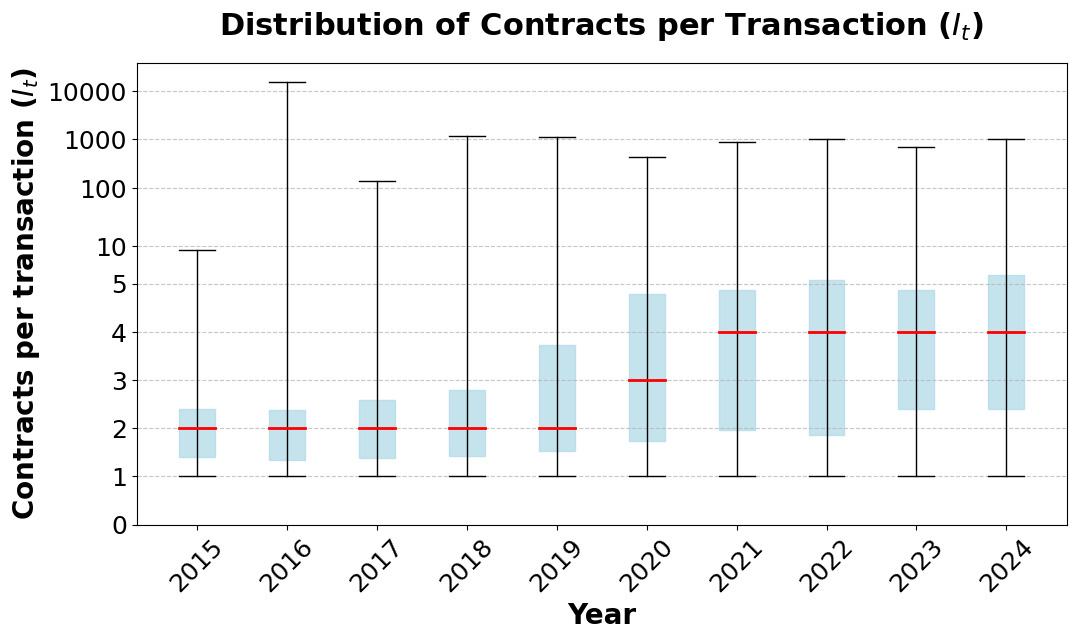

In [30]:

# Define the threshold for the hybrid scale
threshold = 5

# Function to transform the data
def hybrid_scale(y):
    """
    Apply a hybrid scale: linear below the threshold, logarithmic above.
    """
    # Ensure y is a numpy array
    y = np.asarray(y)
    # Apply linear scale for y <= threshold
    linear_part = np.where(y <= threshold, y, 0)
    # Apply logarithmic scale for y > threshold
    log_part = np.where(y > threshold, threshold + np.log10(np.maximum(y - threshold + 1, 1)), 0)
    # Combine the two parts
    return linear_part + log_part

# Function to reverse the transformation (for axis labels)
def hybrid_scale_inverse(y_transformed):
    """
    Reverse the hybrid scale transformation.
    """
    # Ensure y_transformed is a numpy array
    y_transformed = np.asarray(y_transformed)
    # Reverse linear scale for y_transformed <= threshold
    linear_part = np.where(y_transformed <= threshold, y_transformed, 0)
    # Reverse logarithmic scale for y_transformed > threshold
    log_part = np.where(y_transformed > threshold, 10**(y_transformed - threshold) + threshold - 1, 0)
    # Combine the two parts
    return linear_part + log_part

# Load and prepare data
years = range(2015, 2024 + 1)
dfs = []
for year in years:
    dfi = pd.read_csv(f"../results/rq1/contracts_per_tx_{year}.csv")
    dfi["year"] = year
    dfs.append(dfi)

df = pd.concat(dfs)


# Function to calculate weighted percentiles
def weighted_percentile(data, weights, percentiles):
    """
    Calculate weighted percentiles.
    :param data: Array of values.
    :param weights: Array of weights (frequencies).
    :param percentiles: List of percentiles (e.g., [25, 50, 75]).
    :return: Array of percentile values.
    """
    sorted_indices = np.argsort(data)
    sorted_data = data[sorted_indices]
    sorted_weights = weights[sorted_indices]
    cum_weights = np.cumsum(sorted_weights)
    total_weight = cum_weights[-1]
    percentile_positions = total_weight * np.array(percentiles) / 100
    percentiles_values = np.interp(percentile_positions, cum_weights, sorted_data)
    return percentiles_values

# Calculate boxplot statistics for each year
boxplot_stats = []
for year in years:
    df_year = df[df['year'] == year]
    addresses_called = df_year['addresses_called'].values
    frequencies = df_year['frequency'].values
    
    # Calculate weighted percentiles
    min_val = np.min(addresses_called)
    max_val = np.max(addresses_called)
    q1, median, q3 = weighted_percentile(addresses_called, frequencies, [25, 50, 75])
    
    # Store statistics
    boxplot_stats.append({
        'year': year,
        'min': min_val,
        'q1': q1,
        'median': int(np.round(median)),
        'q3': q3,
        'max': max_val
    })

# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_stats)

# Create boxplot manually
plt.figure(figsize=(12, 6))  # Ensure same height
for i, row in boxplot_df.iterrows():
    year = row['year']
    # Transform the data using the hybrid scale
    min_transformed = hybrid_scale(row['min'])
    q1_transformed = hybrid_scale(row['q1'])
    median_transformed = hybrid_scale(row['median'])
    q3_transformed = hybrid_scale(row['q3'])
    max_transformed = hybrid_scale(row['max'])
    
    # Plot the transformed data
    plt.plot([year, year], [min_transformed, max_transformed], color='black', linewidth=1)  # Whiskers
    plt.plot([year - 0.2, year + 0.2], [min_transformed, min_transformed], color='black', linewidth=1)  # Lower whisker cap
    plt.plot([year - 0.2, year + 0.2], [max_transformed, max_transformed], color='black', linewidth=1)  # Upper whisker cap
    plt.fill_between([year - 0.2, year + 0.2], [q1_transformed, q1_transformed], [q3_transformed, q3_transformed], color='lightblue', alpha=0.7)  # Box
    plt.plot([year - 0.2, year + 0.2], [median_transformed, median_transformed], color='red', linewidth=2)  # Median line

# Customize y-axis labels
y_ticks = [0, 1, 2, 3, 4, 5, 10, 100, 1000, 10000]  # Original values
y_tick_labels = [str(x) for x in y_ticks]  # Labels for the original values
y_ticks_transformed = hybrid_scale(np.array(y_ticks))  # Transform the ticks

plt.yticks(y_ticks_transformed, labels=y_tick_labels, fontsize=18)  # Set custom ticks and labels (bold)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines

# Add titles and labels
plt.title("Distribution of Contracts per Transaction ($I_t$)", fontsize=22, pad=20, weight='bold')
plt.xlabel("Year", fontsize=20, weight='bold')
plt.ylabel("Contracts per transaction ($I_t$)", fontsize=20, weight='bold')
plt.xticks(years, rotation=45, fontsize=18)


# plt.tight_layout()

# Save and display the plot
plt.savefig("../figures/rq1/contracts_per_tx_year.pdf", format='pdf', bbox_inches='tight')
plt.show()

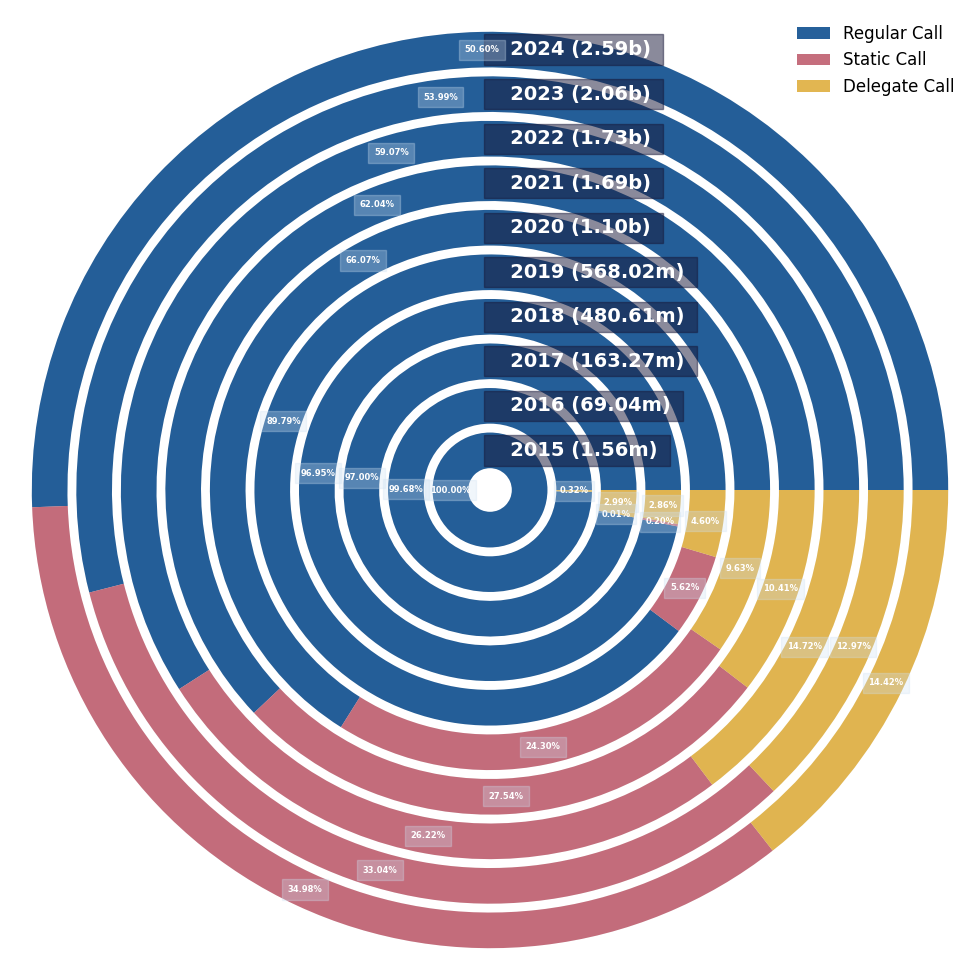

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
from dotenv import load_dotenv
import requests

ETHERSCAN_BASE_URL = "https://api.etherscan.io/v2/api"

# results of Allium
# calls per year RUN_ID
RUN_ID = "3NlwsJ9AuPuV5ws35dKo_20250127T134412_feign"

load_dotenv()
api_key = os.environ.get("ALLIUM_API_KEY")


def get_data():
    response = requests.post(
        f"https://api.allium.so/api/v1/explorer/query-runs/{RUN_ID}/results",
        headers={"X-API-Key": api_key, "Content-Type": "application/json"},
        json={"config": {"limit": 100, "offset": 0}},
        timeout=10,
    )

    data = response.json()
    return data


def abbreviate_number(num):
    if num >= 1e9:
        return f"{num / 1e9:.2f}b"
    elif num >= 1e6:
        return f"{num / 1e6:.2f}m"
    elif num >= 1e3:
        return f"{num / 1e3:.2f}k"
    else:
        return str(num)


def plot_ethereum_circular_radial_chart():
    """
    Plot a circular radial bar chart of Ethereum call types by year.

    Each ring represents a year, and the segments within each ring represent
    different call types. This version uses a stacked approach to ensure
    all call types are visible.
    """
    # Retrieve and prepare data
    raw_data = get_data()
    data = raw_data["data"]
    df = pd.DataFrame(data)
    df["year"] = pd.to_datetime(df["year"]).dt.year
    df = df.sort_values("year")

    # Define call types with their display names and associated colors
    call_types = {
        "call_count_call": ("Regular Call", "#004488"),
        "call_count_staticcall": ("Static Call", "#BB5566"),
        "call_count_delegatecall": ("Delegate Call", "#DDAA33"),
        # 'call_count_callcode': ('Call Code', '#E74C3C')
    }

    # Get unique years for plotting
    years = sorted(df["year"].unique())
    data_len = len(years)

    fig = plt.figure(
        figsize=(12, 12),
        linewidth=10,
    )

    # Positioning the chart in the center with more space
    rect = [0.1, 0.1, 0.8, 0.8]

    # Create the background rings
    ax_polar_bg = fig.add_axes(rect, polar=True, frameon=False)
    ax_polar_bg.set_theta_zero_location("N")  # Start from top
    ax_polar_bg.set_theta_direction(1)  # Go clockwise

    # Prepare year labels with total call counts
    year_labels = []
    for year in years:
        year_row = df[df["year"] == year]
        total_calls = sum(
            year_row[call_type].iloc[0] for call_type in call_types.keys()
        )
        formatted_total = abbreviate_number(total_calls)
        year_labels.append(f"   {year} ({formatted_total}) ")

    # Create full circular background rings
    for i in range(data_len):
        ax_polar_bg.barh(i, 2 * np.pi, color="grey", alpha=0.1, linewidth=9)

    # Hide all axis items for background
    ax_polar_bg.axis("off")

    # Add axis for the actual data
    ax_polar = fig.add_axes(rect, polar=True, frameon=False)
    ax_polar.set_theta_zero_location("N")
    ax_polar.set_theta_direction(1)

    # Set up radius gridlines and labels
    background_color = (23 / 255, 23 / 255, 56 / 255, 0.5)
    ax_polar.set_rgrids(
        range(data_len),
        labels=year_labels,
        angle=0,
        fontsize=14,
        fontweight="bold",
        color="white",
        backgroundcolor=background_color,
        verticalalignment="center",
    )

    for year in years:
        year_row = df[df["year"] == year]


    legend_handles = []

    for i, year in enumerate(years):
        year_row = df[df["year"] == year]

        # Calculate total for this year to normalize to full circle
        total_calls = sum(
            year_row[call_type].iloc[0] for call_type in call_types.keys()
        )


        # Start angle for the first segment
        start_angle = -np.pi / 2  # Start from top (-π/2)

        # Plot each call type as a segment
        for call_type, (name, color) in call_types.items():
            value = year_row[call_type].iloc[0]

            # Calculate what portion of the circle this segment should occupy
            angle = 2 * np.pi * (value / total_calls)

            # Plot the segment
            bar = ax_polar.barh(i, angle, left=start_angle, color=color, alpha=0.85)

            # Move the start angle for the next segment
            start_angle += angle

            # For legend, only add once
            if i == 0:
                legend_handles.append((bar, name))

    # Hide theta grid and labels to create clean circular look
    ax_polar.grid(False)
    ax_polar.set_xticks([])  # Remove angular ticks
    ax_polar.tick_params(axis="both", left=False, bottom=False, labelbottom=False)

    # Add a legend
    legend_items = [handle for handle, _ in legend_handles]
    legend_labels = [label for _, label in legend_handles]
    plt.legend(
        legend_items,
        legend_labels,
        loc="upper right",
        fontsize=12,
        frameon=True,
        edgecolor="white",
        framealpha=0.8,
    )

    # Add annotations for each segment
    for i, year in enumerate(years):
        year_row = df[df["year"] == year]
        start_angle = -np.pi / 2

        for call_type, (name, _) in call_types.items():
            value = year_row[call_type].iloc[0]
            total_calls = sum(
                year_row[call_type].iloc[0] for call_type in call_types.keys()
            )
            percentage = (value / total_calls) * 100
            # print(f"{name} Percentage for {year}: {percentage}")

            # Only add annotation if segment is large enough
            if percentage == 0:
                continue

            angle = 2 * np.pi * (value / total_calls)
            mid_angle = start_angle + (angle / 2)

            # percentage text
            background_color_label = (207 / 255, 226 / 255, 243 / 255, 0.3)

            ax_polar.text(
                mid_angle,
                i,
                f"{percentage:.2f}%",
                ha="center",
                va="center",
                fontsize=6,
                color="white",
                fontweight="bold",
                backgroundcolor=background_color_label,
            )

            start_angle += angle

    plt.savefig("ethereum_circular_chart.pdf", dpi=300, bbox_inches="tight")
    plt.show()


if __name__ == "__main__":
    plot_ethereum_circular_radial_chart()


## RQ2: Which are the most prolific creators of smart contracts?
Metrics:
- Contracts created by EOA
- Contracts created by Contracts

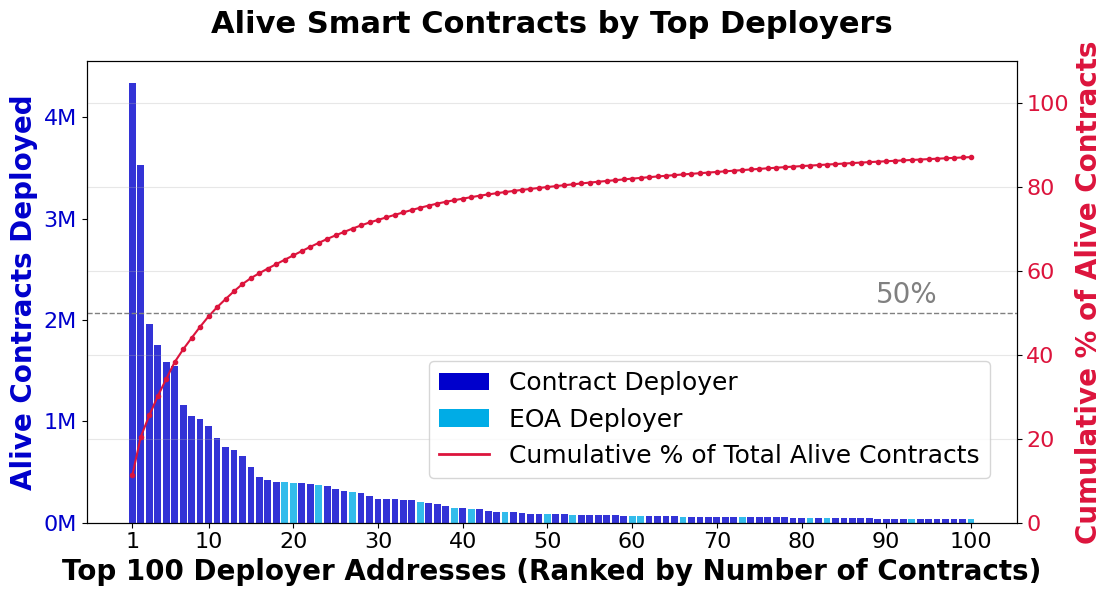

In [31]:

# Load the data
df = pd.read_csv("../results/rq2/top_deployers_alive.csv")
eoa_df = pd.read_csv("../results/rq2/top_eoa_deployers_filtered.csv")

# Sort the data
df = df.sort_values(by="deployed_alive_contracts", ascending=False)

# Compute cumulative sum and proportion
total_alive_contracts = df["deployed_alive_contracts"].sum()
df["cumulative_sum"] = df["deployed_alive_contracts"].cumsum()
df["cumulative_proportion"] = df["cumulative_sum"] / total_alive_contracts * 100

# Limit to top 51 addresses
df = df.iloc[:100].reset_index(drop=True)

# Set bar colors: light blue for EOAs, dark blue for others
eoa_addresses = set(eoa_df["address"])
df["color"] = df["address"].apply(lambda x: '#00ace6' if x in eoa_addresses else '#0000cc')  # Light blue vs default blue

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart
bars = ax1.bar(df.index, df["deployed_alive_contracts"], color=df["color"], alpha=0.8, label='Alive Contracts Deployed')
ax1.set_xlabel("Top 100 Deployer Addresses (Ranked by Number of Contracts)", fontsize=20)
# Define the custom x-ticks you want to show
xticks_to_show = [0] + [i for i in range(9, len(df), 10)]  # 0-indexed, so 0 (for 1), 9 (for 10), 19 (for 20), etc.
xtick_labels = [i + 1 for i in xticks_to_show]             # Convert to 1-based labels

# Apply the custom ticks
ax1.set_xticks(xticks_to_show)
ax1.set_xticklabels(xtick_labels)
ax1.set_ylabel("Alive Contracts Deployed", color='#0000cc', fontsize=20)
ax1.tick_params(axis='y', labelcolor='#0000cc')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

# Line chart
ax2 = ax1.twinx()
ax2.plot(df.index, df["cumulative_proportion"], marker='.', linestyle='-', color='crimson', label='Cumulative % of Total Alive Contracts')
ax2.set_ylabel("Cumulative % of Alive Contracts", color='crimson', fontsize=20)
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.set_ylim(0, 110)
ax2.axhline(50, color='gray', linestyle='--', linewidth=1)
ax2.text(len(df)*0.95, 51, '50%', color='gray', ha='right', va='bottom', fontsize=20)

# Title and grid
plt.title("Alive Smart Contracts by Top Deployers", fontsize=22, fontweight='bold', pad=20)
plt.grid(alpha=0.3)

# Legend

legend_elements = [
    Patch(facecolor='#0000cc', label='Contract Deployer'),
    Patch(facecolor='#00ace6', label='EOA Deployer'),
    plt.Line2D([0], [0], color='crimson', lw=2, label='Cumulative % of Total Alive Contracts')
]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.4, 0.4), fontsize=18)

plt.rcParams.update({
    'font.size': 20,  # General font size
    'axes.labelsize': 20,  # Bigger axis labels
    'axes.labelweight': 'bold',
    'axes.titlesize': 20,  # Bigger title
    'xtick.labelsize': 20,  # Bigger tick labels
    'ytick.labelsize': 20,
    'legend.fontsize': 20  # Bigger legend
})

# plt.tight_layout()
plt.savefig("../figures/rq2/top_100_deployers.pdf", format='pdf', bbox_inches='tight')
plt.show()


# RQ3: Most called contract

In [10]:
import pandas as pd
import plotly.graph_objects as go
import requests
import os
from dotenv import load_dotenv

# Config
df = pd.read_csv("../results/rq3/top_callee_labelled.csv", sep=";")


# Filter out callcode
df = df[df["call_type"] != "callcode"]

# Ensure to_address is filled
df["to_address"] = df["to_address"].fillna("Unknown Callee")

# Optional: Apply label mapping if 'label' is present
if "label" in df.columns:
    label_map = df.set_index("to_address")["label"].dropna().to_dict()
    df["to_address"] = df["to_address"].map(label_map).fillna(df["to_address"])

# Proportions
top_call_proportion = "28.71%"
top_delegate_call_proportion = "31.03%"
top_static_call_proportion = "41.31%"

# Define nodes: unique call_types + to_addresses
nodes = list(set(df["call_type"]).union(df["to_address"]))
node_indices = {node: i for i, node in enumerate(nodes)}

# Create links from call_type to to_address
links = [
    {
        "source": node_indices[row["call_type"]],
        "target": node_indices[row["to_address"]],
        "value": row["call_count"],
    }
    for _, row in df.iterrows()
]


node_labels = [
    f"{node} ({top_call_proportion})"
    if node == "call"
    else f"{node} ({top_delegate_call_proportion})"
    if node == "delegatecall"
    else f"{node} ({top_static_call_proportion})"
    if node == "staticcall"
    else node
    for node in nodes
]


# Create the Sankey diagram
fig = go.Figure(
    go.Sankey(
        node=dict(
            pad=15, thickness=20, line=dict(color="black", width=0.5), label=node_labels
        ),
        link=dict(
            source=[link["source"] for link in links],
            target=[link["target"] for link in links],
            value=[link["value"] for link in links],
        ),
    )
)


fig.update_layout(
    title_text="Different Types of Calls to Top Callee Contracts",
    font_size=10,
    width=800,  # Set the width of the figure
    height=800,
)

fig.show()
fig.write_image("sankey_diagram.png")


## RQ4: How transparent are smart contract calls inter-actions in major DeFi protocols?
Study cases:
- Uniswap
- Lido

### Uniswap Study Case

In [105]:
plt.rcParams.update({
    'font.size': 14,  # General font size
    'axes.labelsize': 14,  # Bigger axis labels
    'axes.labelweight': 'bold',
    'axes.titlesize': 14,  # Bigger title
    'xtick.labelsize': 14,  # Bigger tick labels
    'ytick.labelsize': 14,
    'legend.fontsize': 14  # Bigger legend
})

Number of unique from addresses: 31
Number of all nodes: 77
Number of nodes in each color group:
Color group 0: 25 nodes
Color group 1: 34 nodes
Color group 2: 18 nodes
Number of unverified nodes in each color group:
Color group 0: 7 unverified nodes
Color group 1: 0 unverified nodes
Color group 2: 0 unverified nodes


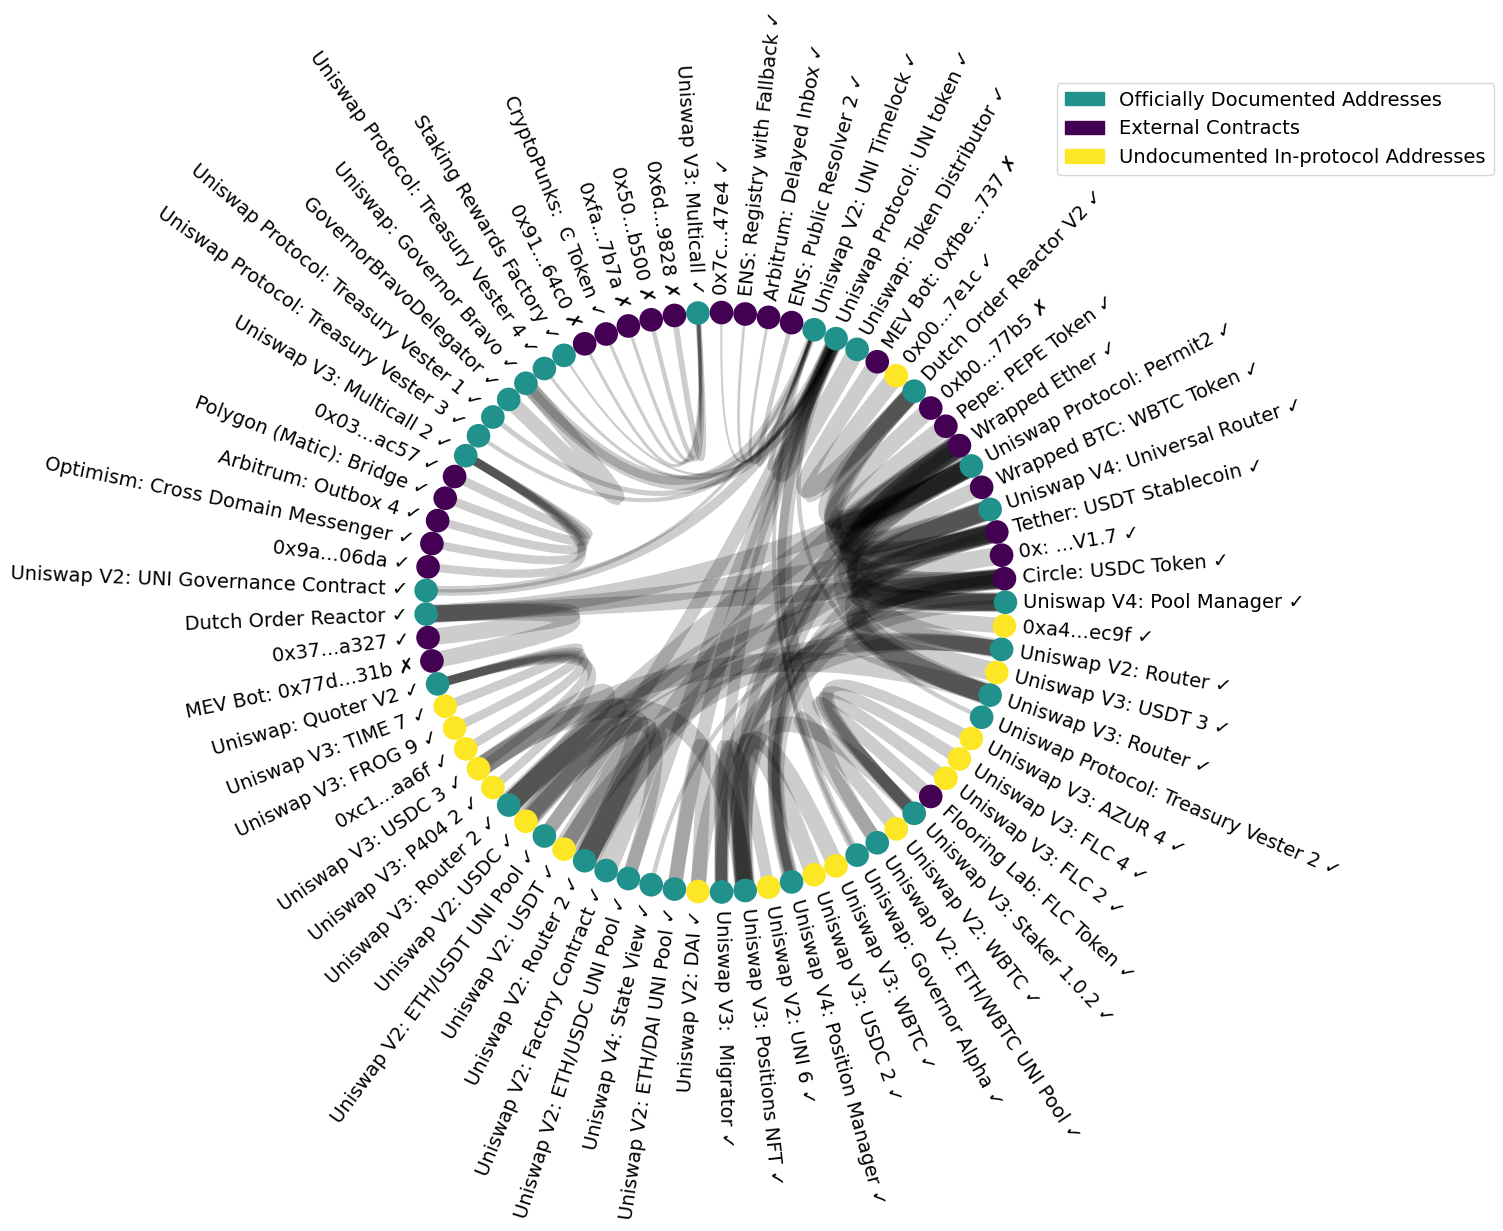

In [ ]:
from utils import get_etherscan_label, get_etherscan_verification

official_labels_file_path = "../results/rq4/uniswap_labels.csv"
contracts_file_path = "../results/rq4/uniswap_top_5_to_addr.csv"
creators_file_path = "../results/rq4/uniswap_undocumented_inprotocol.csv"


def load_data(contracts_file, labels_file, creators_file):
    """Load contracts and address labels data from CSV files."""
    data = pd.read_csv(contracts_file)
    data["from_address"] = data["from_address"].str.lower()
    data["to_address"] = data["to_address"].str.lower()
    
    address_labels = pd.read_csv(labels_file)
    address_labels["address"] = address_labels["address"].str.lower()
    
    creators = pd.read_csv(creators_file)
    creators["to_address"] = creators["to_address"].str.lower()
    creators["from_address"] = creators["from_address"].str.lower()
   
    created = creators["to_address"].unique()
    to_addresses = data["to_address"].unique()
    from_addresses = data["from_address"].unique()
    print(f"Number of unique from addresses: {len(from_addresses)}")


    addresses_w_label = address_labels["address"].unique()
    addresses_wo_label = [address for address in to_addresses if address not in addresses_w_label]

    # get the labels for the addresses that are not in the labels
    for addr in addresses_wo_label:
        label = get_etherscan_label(addr)
        verified = get_etherscan_verification(addr)
        address_labels.loc[len(address_labels)] = [addr, False, label, verified]
    # update labels file
    address_labels.to_csv(labels_file, index=False)
    # Create a dictionary for quick label lookup (keys in lowercase)
    address_group_dict = {
        k.lower(): bool(v) for k, v in zip(address_labels["address"], address_labels["uniswap"])
    }
    address_label_dict = {
        k.lower(): v for k, v in zip(address_labels["address"], address_labels["label"]) if pd.notna(v)
    }
    verified_dict = {
        k.lower(): bool(v) for k, v in zip(address_labels["address"], address_labels["verified"]) if pd.notna(v)
    }
    return data, address_label_dict, address_group_dict, verified_dict, created


def build_graph(data):
    """Create a graph from the contract interactions data."""
    G = nx.Graph()
    for _, row in data.iterrows():
        G.add_edge(
            row["from_address"].lower(),
            row["to_address"].lower(),
            weight=row["call_count"],
        )
    return G


def remove_invalid_nodes(G):
    """Remove nodes with addresses starting with the invalid pattern."""
    invalid_nodes = [
        node
        for node in G.nodes()
        if str(node).startswith("0x000000000000000000000000000000000000000")
    ]
    G.remove_nodes_from(invalid_nodes)
    return G


def relabel_nodes_with_labels(G, address_label_dict, verified_dict):
    """
    Relabel nodes using the provided address labels dictionary.
    Then, shorten long hexadecimal addresses and append the verification tick.
    """
    for node in G.nodes():
        is_verified = verified_dict.get(node, False)
        G.nodes[node]["verified"] = "✓" if is_verified else "✗"
    G = nx.relabel_nodes(G, address_label_dict)
    G = nx.relabel_nodes(
        G, lambda x: x[:4] + "..." + x[-4:] if str(x).startswith("0x") else x
    )
    G = nx.relabel_nodes(G, lambda x: x + " " + str(G.nodes[x]["verified"]))
    return G


def apply_edge_transformations(G):
    """Apply logarithmic transformation to the edge weights."""
    for u, v, d in G.edges(data=True):
        d["log_weight"] = np.log1p(d["weight"])
    return G


def assign_color_groups(G, address_group_dict, created):
    """
    Assign a color group to each node based on whether it is an address.
    Nodes that start with '0x' are group 0; all others are group 1.
    """
    for node in G.nodes():
        if address_group_dict.get(str(node)) == True:
            G.nodes[node]["color_group"] = 1
        elif str(node) in created:
            G.nodes[node]["color_group"] = 2
        else:
            G.nodes[node]["color_group"] = 0
    return G


def generate_plot(G):
    """Generate a circos plot of the network using nxviz and save the output."""
    plt.figure(figsize=(15, 15))
    nv.circos(G, node_color_by="color_group", edge_lw_by="log_weight")
    annotate.circos_labels(G, layout="rotate")
    labels = ["Officially Documented Addresses",
               "External Contracts",
               "Undocumented In-protocol Addresses"
               ]
        
    legends = {
        # "loc": "lower left",
        "borderaxespad": 0.5,
        "title_fontsize": 10,
        "labels": labels,
        "bbox_to_anchor": (1, 1.13),
    }

    annotate.node_colormapping(G, "color_group", legend_kwargs=legends)
    plt.tight_layout()
    plt.savefig("../figures/rq4/uniswap_network.pdf", format='pdf', bbox_inches='tight')
    plt.show()


def print_node_statistics(G):       
    """Print the number of nodes and their distribution by color group."""
    print(f"Number of all nodes: {len(G.nodes())}")
    color_group_counts = {0: 0, 1: 0, 2: 0}
    unverified_count = {0: 0, 1: 0, 2: 0}
    for node in G.nodes():
        color_group = G.nodes[node]["color_group"]
        color_group_counts[color_group] += 1
        if G.nodes[node]["verified"] == "✗":
            unverified_count[color_group] += 1
    print("Number of nodes in each color group:")
    for group, count in color_group_counts.items():
        print(f"Color group {group}: {count} nodes")
    print("Number of unverified nodes in each color group:")
    for group, count in unverified_count.items():
        print(f"Color group {group}: {count} unverified nodes")


# Load data and build initial graph
data, address_label_dict, address_group_dict, verified_dict, created = load_data(contracts_file_path, official_labels_file_path, creators_file_path)
G = build_graph(data)
G = remove_invalid_nodes(G)



# Apply transformations to edge weights and assign color groups to nodes
G = apply_edge_transformations(G)
G = assign_color_groups(G, address_group_dict, created)
# Relabel nodes with official labels and verification ticks
G = relabel_nodes_with_labels(G, address_label_dict, verified_dict)

# Print some statistics about the graph
print_node_statistics(G)

# Generate and save the network plot
generate_plot(G)



Number of nodes in the graph: 97
Number of nodes in the graph(precompiled removed): 94
Color group counts: {0: 16, 1: 53, 2: 25, 3: 0}
Number of nodes in the graph: 94


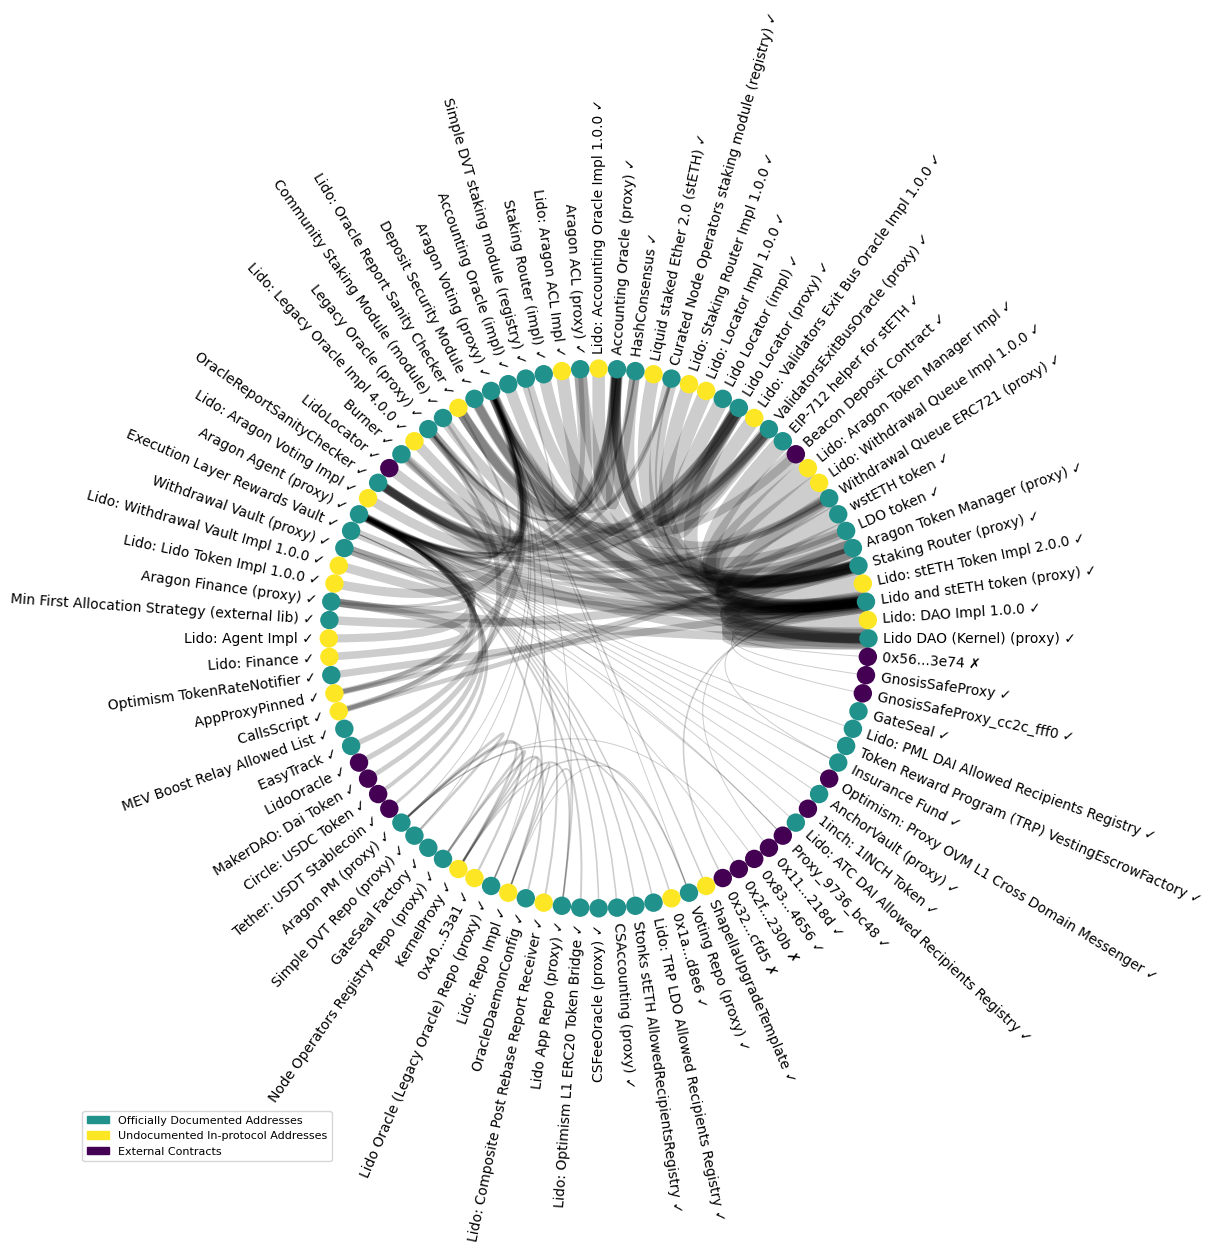

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import nxviz as nv
from nxviz import annotate
import pandas as pd
import numpy as np
import requests
import requests_cache
import os
from dotenv import load_dotenv


# Load environment variables from a .env file
load_dotenv()

# Read provided data
data = pd.read_csv("../results/rq4/lido_interactions.csv")
# https://github.com/lidofinance/docs/blob/f7a06fd0d5fe082e711466f5b11b519db54e2cd7/docs/deployed-contracts/index.md
address_labels = pd.read_csv("../results/rq4/lido_addr_and_label_web.csv")
name_tags = pd.read_csv("../results/rq4/lido_address_name_tags.csv")

# Set up request caching and API keys
requests_cache.install_cache("etherscan_cache")
etherscan_api_key = os.getenv("ETHERSCAN_API_KEY")
blocksec_api_key = "04ffa746390e547652dc81d22f4b6770762d6da026ea035737211809f1e643d7"


def get_contract_verification_status(contract_address, api_key):
    url = "https://api.etherscan.io/api"
    params = {
        "module": "contract",
        "action": "getabi",
        "address": contract_address,
        "apikey": api_key,
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        result = response.json()
        if (
            result["status"] == "1"
            and result["result"] != "Contract source code not verified"
        ):
            return True  # Contract is verified
        else:
            return False  # Contract is not verified
    else:
        return None  # API request failed


# Create a dictionary for official address labels (keys are lowercase)
address_label_dict = {
    k.lower(): v for k, v in zip(address_labels["address"], address_labels["label"])
}

# Build the graph from provided data
G = nx.Graph()

# print the number of nodes in the graph

for _, row in data.iterrows():
    src = row["from_address"].lower()
    tgt = row["to_address"].lower()
    G.add_edge(src, tgt, weight=row["call_count"])


print(f"Number of nodes in the graph: {len(G.nodes())}")


# Remove precompiled contract nodes (using the full 42-character prefix)
G.remove_nodes_from(
    [
        node
        for node in G.nodes()
        if str(node).startswith("0x00000000000000000000000000000000000000")
    ]
)

print(f"Number of nodes in the graph(precompiled removed): {len(G.nodes())}")


# Set the original address and verification status for each node
for node in list(G.nodes()):
    G.nodes[node]["original_address"] = node  # preserve the original address
    is_verified = get_contract_verification_status(node, etherscan_api_key)
    G.nodes[node]["verified"] = "✓" if is_verified else "✗"

# Create a dictionary for name tags: map address to a tuple (name_tag, category)
name_tags_dict = {
    row["address"].lower(): (row["name_tag"], row["category"])
    for _, row in name_tags.iterrows()
}


# Assign initial color groups based on official labels and Lido deployment
for node in G.nodes():
    if node in address_label_dict:  # node is in the official list
        G.nodes[node]["color_group"] = 1
    elif node in name_tags_dict and name_tags_dict[node][1] == "Lido":
        # print(f"{node}")
        G.nodes[node]["color_group"] = 2
    elif node in name_tags_dict and name_tags_dict[node][1] == "External":
        G.nodes[node]["color_group"] = 0
    else:
        # Assign a default color group if no specific category is found
        G.nodes[node]["color_group"] = 3  # Default or unknown category
        print(f"{node}")
# Count the number of nodes in each color group
color_group_counts = {0: 0, 1: 0, 2: 0, 3: 0}  # Include the default group
for node in G.nodes():
    color_group_counts[G.nodes[node]["color_group"]] += 1
print("Color group counts:", color_group_counts)

print("Number of nodes in the graph:", len(G.nodes()))

# Build a mapping for relabeling nodes using name tags or official labels
mapping = {}
for node in G.nodes():
    original = G.nodes[node]["original_address"]
    if original in name_tags_dict and pd.notnull(name_tags_dict[original][0]):
        new_label = name_tags_dict[original][0]
    elif original in address_label_dict:
        new_label = address_label_dict[original]
    else:
        new_label = original[:4] + "..." + original[-4:]
    new_label = new_label + " " + G.nodes[node]["verified"]
    mapping[node] = new_label

# Relabel nodes in the graph
G = nx.relabel_nodes(G, mapping)

# Apply a logarithmic transformation to the edge weights
for u, v, d in G.edges(data=True):
    d["log_weight"] = np.log1p(d["weight"])  # log1p safely handles zero weights

# Create the network diagram using nxviz's circos layout
# make node font bigger
plt.figure(figsize=(13, 13))
palette = ["#800080", "#DA70D6", "#FFFF00"]
nv.circos(G, node_palette=palette, node_color_by="color_group", edge_lw_by="log_weight")

legend_labels = [
    "Officially Documented Addresses",
    "Undocumented In-protocol Addresses",
    "External Contracts",
]
legend_kwargs = {
    "loc": "lower left",
    "borderaxespad": 0.5,
    "labels": legend_labels,
    "fontsize": 8,
    "bbox_to_anchor": (-0.35, -0.36),
}

# Annotate the labels on the plot
plt.subplots_adjust(top=0.3)
annotate.circos_labels(G, layout="rotate")
annotate.node_colormapping(G, color_by="color_group", legend_kwargs=legend_kwargs)


plt.tight_layout()
plt.savefig("fix_network_diagram_with_labels_final.pdf")
